In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import initialize_parameters, forward_propagation, compute_cost, backward_propagation, predict, predict_dec
from opt_utils_v1a import load_dataset, load_params_and_grads, plot_decision_boundary
from copy import deepcopy
from testCases import *
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent. 

<a name='ex-1'></a>
### Exercise 1 - update_parameters_with_gd

Implement the gradient descent update rule. The  gradient descent rule is, for $l = 1, ..., L$: 
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

where L is the number of layers and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary. Note that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$. 

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2

    for l in range(1, L+1):
        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate * grads["dW"+str(l)]
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate * grads["db"+str(l)]

    return parameters

In [3]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()
learning_rate = 0.01
parameters = update_parameters_with_gd(parameters, grads, learning_rate)

print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

update_parameters_with_gd_test(update_parameters_with_gd)

W1 =
[[ 1.63312395 -0.61217855 -0.5339999 ]
 [-1.06196243  0.85396039 -2.3105546 ]]
b1 =
[[ 1.73978682]
 [-0.77021546]]
W2 =
[[ 0.32587637 -0.24814147]
 [ 1.47146563 -2.05746183]
 [-0.32772076 -0.37713775]]
b2 =
[[ 1.13773698]
 [-1.09301954]
 [-0.16397615]]
All tests passed


<a name='3'></a>
## 3 - Mini-Batch Gradient Descent

Now you'll build some mini-batches from the training set (X, Y).

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

<img src="images/kiank_shuffle.png" style="width:550px;height:300px;">

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

<img src="images/kiank_partition.png" style="width:550px;height:300px;">

<a name='ex-2'></a>
### Exercise 2 - random_mini_batches

Implement `random_mini_batches`. The shuffling part has already been coded for you! To help with the partitioning step, you've been provided the following code that selects the indexes for the $1^{st}$ and $2^{nd}$ mini-batches:
```python
first_mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
second_mini_batch_X = shuffled_X[:, mini_batch_size : 2 * mini_batch_size]
...
```

Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be $\left(m-mini_\_batch_\_size \times \left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor\right)$. 

**Hint:**

$$mini\_batch\_X = shuffled\_X[:, i : j]$$ 

Think of a way in which you can use the for loop variable `k` help you increment `i` and `j` in multiples of mini_batch_size.

As an example, if you want to increment in multiples of 3, you could the following:

```python
n = 3
for k in (0 , 5):
    print(k * n)
```

In [9]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    inc = mini_batch_size

    num_complete_minbatches = math.floor(m / mini_batch_size)
    for k in range(num_complete_minbatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minbatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minbatches * mini_batch_size : m]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [10]:
np.random.seed(1)
mini_batch_size = 64
nx = 12288
m = 148
X = np.array([x for x in range(nx * m)]).reshape((m, nx)).T
Y = np.random.randn(1, m) < 0.5

mini_batches = random_mini_batches(X, Y, mini_batch_size)
n_batches = len(mini_batches)

assert n_batches == math.ceil(m / mini_batch_size), f"Wrong number of mini batches. {n_batches} != {math.ceil(m / mini_batch_size)}"
for k in range(n_batches - 1):
    assert mini_batches[k][0].shape == (nx, mini_batch_size), f"Wrong shape in {k} mini batch for X"
    assert mini_batches[k][1].shape == (1, mini_batch_size), f"Wrong shape in {k} mini batch for Y"
    assert np.sum(np.sum(mini_batches[k][0] - mini_batches[k][0][0], axis=0)) == ((nx * (nx - 1) / 2 ) * mini_batch_size), "Wrong values. It happens if the order of X rows(features) changes"
if ( m % mini_batch_size > 0):
    assert mini_batches[n_batches - 1][0].shape == (nx, m % mini_batch_size), f"Wrong shape in the last minibatch. {mini_batches[n_batches - 1][0].shape} != {(nx, m % mini_batch_size)}"

assert np.allclose(mini_batches[0][0][0][0:3], [294912,  86016, 454656]), "Wrong values. Check the indexes used to form the mini batches"
assert np.allclose(mini_batches[-1][0][-1][0:3], [1425407, 1769471, 897023]), "Wrong values. Check the indexes used to form the mini batches"

print("\033[92mAll tests passed!")

All tests passed!


In [11]:
t_X, t_Y, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(t_X, t_Y, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

random_mini_batches_test(random_mini_batches)

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]
 All tests passed.


<a name='4'></a>
## 4 - Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 

<img src="images/opt_momentum.png" style="width:400px;height:250px;">
<caption><center> <u><font color='purple'><b>Figure 3</b> </u><font color='purple'>: The red arrows show the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, the gradient is allowed to influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center>

<a name='ex-3'></a>    
### Exercise 3 - initialize_velocity
Initialize the velocity. The velocity, $v$, is a python dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the `grads` dictionary, that is:
for $l =1,...,L$:
```python
v["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
v["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
```
**Note** that the iterator l starts at 1 in the for loop as the first parameters are v["dW1"] and v["db1"] (that's a "one" on the superscript).

In [12]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    L = len(parameters) // 2
    v = {}

    for l in range(1, L+1):
        v["dW"+str(l)] = np.zeros(parameters["W"+str(l)].shape)
        v["db"+str(l)] = np.zeros(parameters["b"+str(l)].shape)

    return v

In [13]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

initialize_velocity_test(initialize_velocity)

v["dW1"] =
[[0. 0.]
 [0. 0.]
 [0. 0.]]
v["db1"] =
[[0.]
 [0.]
 [0.]]
v["dW2"] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] =
[[0.]
 [0.]
 [0.]]
 All tests passed.


<a name='ex-4'></a>   
### Exercise 4 - update_parameters_with_momentum

Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript).

In [14]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2

    for l in range(1, L+1):
        v["dW"+str(l)] = beta * v["dW"+str(l)] + (1-beta)*grads["dW"+str(l)]
        v["db"+str(l)] = beta * v["db"+str(l)] + (1-beta)*grads["db"+str(l)]

        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate * v["dW"+str(l)]
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate * v["db"+str(l)]

    return parameters, v

In [15]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

update_parameters_with_momentum_test(update_parameters_with_momentum)

W1 = 
[[ 1.62522322 -0.61179863 -0.52875457]
 [-1.071868    0.86426291 -2.30244029]]
b1 = 
[[ 1.74430927]
 [-0.76210776]]
W2 = 
[[ 0.31972282 -0.24924749]
 [ 1.46304371 -2.05987282]
 [-0.32294756 -0.38336269]]
b2 = 
[[ 1.1341662 ]
 [-1.09920409]
 [-0.171583  ]]
v["dW1"] = 
[[-0.08778584  0.00422137  0.05828152]
 [-0.11006192  0.11447237  0.09015907]]
v["db1"] = 
[[0.05024943]
 [0.09008559]]
v["dW2"] = 
[[-0.06837279 -0.01228902]
 [-0.09357694 -0.02678881]
 [ 0.05303555 -0.06916608]]
v["db2"] = v[[-0.03967535]
 [-0.06871727]
 [-0.08452056]]
 All tests passed.


**Note that**:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update, because it takes the past gradients into account more. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might require trying several values to see what works best in terms of reducing the value of the cost function $J$. 

<a name='5'></a>   
## 5 - Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, all parameters are stored in the `parameters` dictionary  

<a name='ex-5'></a>   
### Exercise 5 - initialize_adam

Initialize the Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables $v, s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for `grads`, that is:
for $l = 1, ..., L$:
```python
v["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
v["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
s["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
s["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])

```

In [17]:
def initialize_adam(parameters):
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(1, L+1):
        v["dW"+str(l)] = np.zeros(parameters["W"+str(l)].shape)
        v["db"+str(l)] = np.zeros(parameters["b"+str(l)].shape)
        s["dW"+str(l)] = np.zeros(parameters["W"+str(l)].shape)
        s["db"+str(l)] = np.zeros(parameters["b"+str(l)].shape)

    return v, s

In [18]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

initialize_adam_test(initialize_adam)

v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]
 All tests passed.


<a name='ex-6'></a>   
### Exercise 6 - update_parameters_with_adam

Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$.

In [24]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(1, L+1):
        v["dW"+str(l)] = beta1 * v["dW"+str(l)] + (1-beta1) * grads["dW"+str(l)]
        v["db"+str(l)] = beta1 * v["db"+str(l)] + (1-beta1) * grads["db"+str(l)]

        v_corrected["dW"+str(l)] = v["dW"+str(l)] / (1 - beta1 ** t)
        v_corrected["db"+str(l)] = v["db"+str(l)] / (1 - beta1 ** t)

        s["dW"+str(l)] = beta2 * s["dW"+str(l)] + (1-beta2) * (grads["dW"+str(l)] ** 2)
        s["db"+str(l)] = beta2 * s["db"+str(l)] + (1-beta2) * (grads["db"+str(l)] ** 2)

        s_corrected["dW"+str(l)] = s["dW"+str(l)] / (1 - beta2 ** t)
        s_corrected["db"+str(l)] = s["db"+str(l)] / (1 - beta2 ** t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - learning_rate * v_corrected["dW"+str(l)] / (np.sqrt(s_corrected["dW"+str(l)]) + epsilon)
        parameters["b"+str(l)] = parameters["b"+str(l)] - learning_rate * v_corrected["db"+str(l)] / (np.sqrt(s_corrected["db"+str(l)]) + epsilon)

    return parameters, v, s, v_corrected, s_corrected

In [25]:
parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon = update_parameters_with_adam_test_case()

parameters, v, s, vc, sc  = update_parameters_with_adam(parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon)
print(f"W1 = \n{parameters['W1']}")
print(f"W2 = \n{parameters['W2']}")
print(f"b1 = \n{parameters['b1']}")
print(f"b2 = \n{parameters['b2']}")

update_parameters_with_adam_test(update_parameters_with_adam)

W1 = 
[[ 1.63937725 -0.62327448 -0.54308727]
 [-1.0578897   0.85032154 -2.31657668]]
W2 = 
[[ 0.33400549 -0.23563857]
 [ 1.47715417 -2.04561842]
 [-0.33729882 -0.36908457]]
b1 = 
[[ 1.72995096]
 [-0.7762447 ]]
b2 = 
[[ 1.14852557]
 [-1.08492339]
 [-0.15740527]]
All tests passed


<a name='6'></a>  
## 6 - Model with different Optimization algorithms

Below, you'll use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.) 

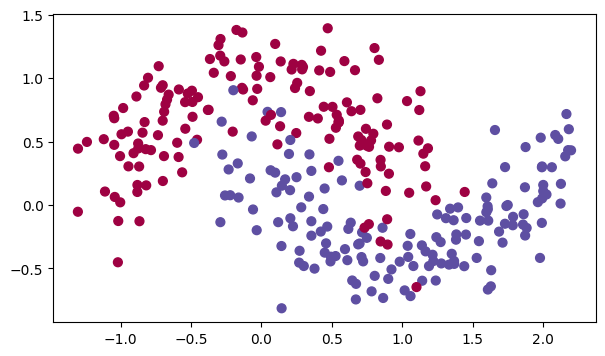

In [26]:
train_X, train_Y = load_dataset()

In [40]:
def model(X, Y, layer_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9, beta1 = 0.9, beta2 = 0.999, epsilon=1e-8, num_epochs=5000, print_cost=True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layer_dims)
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]

    parameters = initialize_parameters(layer_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches:
            (mini_batch_X, mini_batch_Y) = minibatch

            a3, cache = forward_propagation(mini_batch_X, parameters)

            cost_total += compute_cost(a3, mini_batch_Y)

            grads = backward_propagation(mini_batch_X, mini_batch_Y, cache)

            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t += 1
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        cost_avg = cost_total / m

        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)

    plt.plot(costs)
    plt.ylabel("cost")
    plt.xlabel("epochs (per 100)")
    plt.title("Learning rate="+str(learning_rate))
    plt.show()
    
    return parameters    

<a name='6-1'></a>  
### 6.1 - Mini-Batch Gradient Descent

Run the following code to see how the model does with mini-batch gradient descent.

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367


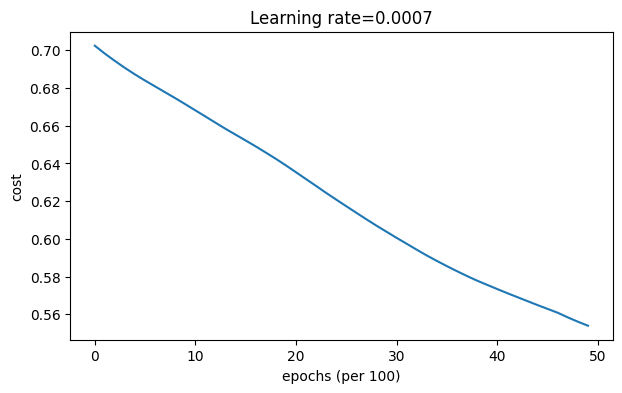

Accuracy: 0.7166666666666667


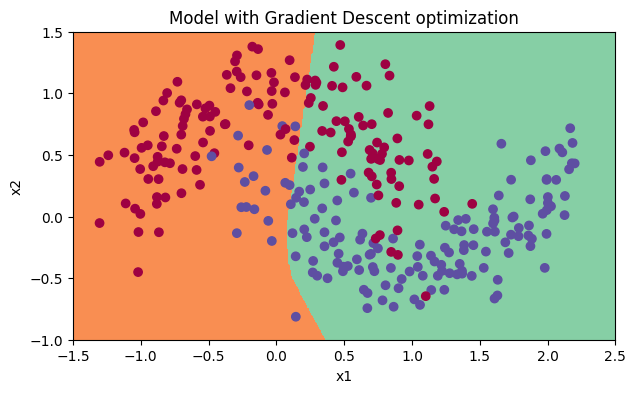

In [38]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<a name='6-2'></a>  
### 6.2 - Mini-Batch Gradient Descent with Momentum

Next, run the following code to see how the model does with momentum. Because this example is relatively simple, the gains from using momemtum are small - but for more complex problems you might see bigger gains.

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444


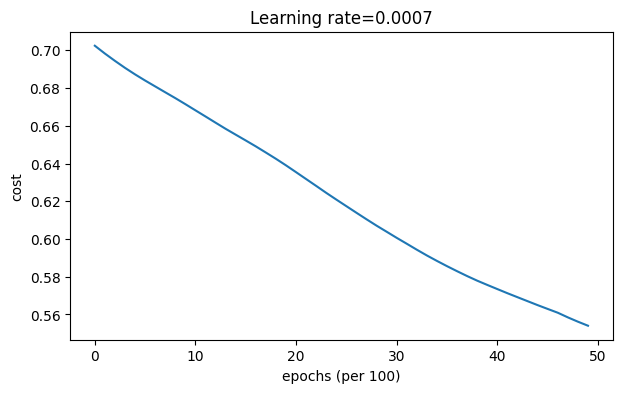

Accuracy: 0.7166666666666667


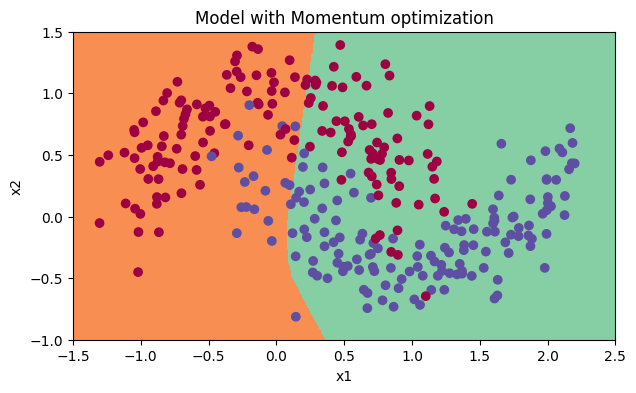

In [41]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<a name='6-3'></a>  
### 6.3 - Mini-Batch with Adam

Finally, run the following code to see how the model does with Adam.

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066


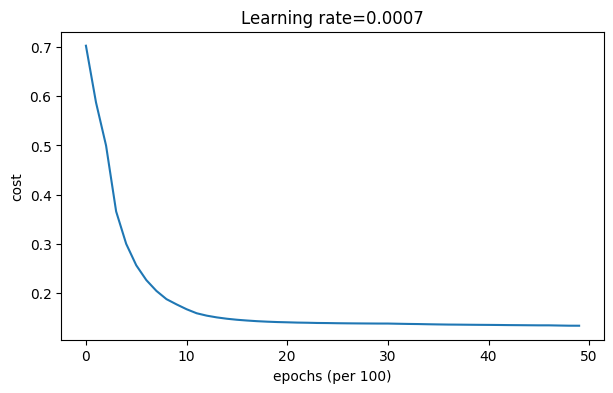

Accuracy: 0.9433333333333334


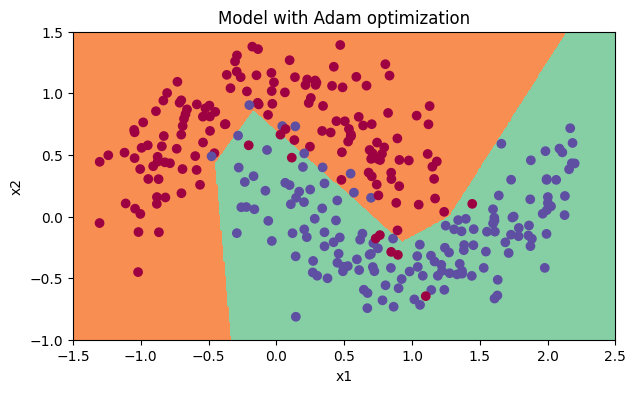

In [42]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<a name='6-4'></a>  
### 6.4 - Summary

<table> 
    <tr>
        <td>
        <b>optimization method</b>
        </td>
        <td>
        <b>accuracy</b>
        </td>
        <td>
        <b>cost shape</b>
        </td>
    </tr>
        <td>
        Gradient descent
        </td>
        <td>
        >71%
        </td>
        <td>
        smooth
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        >71%
        </td>
        <td>
        smooth
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        >94%
        </td>
        <td>
        smoother
        </td>
    </tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligible.

On the other hand, Adam clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:

- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

<a name='7'></a>  
## 7 - Learning Rate Decay and Scheduling

Lastly, the learning rate is another hyperparameter that can help you speed up learning. 

During the first part of training, your model can get away with taking large steps, but over time, using a fixed value for the learning rate alpha can cause your model to get stuck in a wide oscillation that never quite converges. But if you were to slowly reduce your learning rate alpha over time, you could then take smaller, slower steps that bring you closer to the minimum. This is the idea behind learning rate decay. 

Learning rate decay can be achieved by using either adaptive methods or pre-defined learning rate schedules. 

Now, you'll apply scheduled learning rate decay to a 3-layer neural network in three different optimizer modes and see how each one differs, as well as the effect of scheduling at different epochs. 

This model is essentially the same as the one you used before, except in this one you'll be able to include learning rate decay. It includes two new parameters, decay and decay_rate. 

In [43]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=5000, print_cost=True, decay=None, decay_rate=1):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]
    lr_rates = []
    learning_rate0 = learning_rate

    parameters = initialize_parameters(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters, beta)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters, beta1, beta2)

    for i in range(num_epochs):
        seed += 1
        mini_batches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for mini_batch in mini_batches:
            (mini_batch_X, mini_batch_Y) = mini_batch

            a3, caches = forward_propagation(mini_batch_X, parameters)

            cost_total += compute_cost(a3, mini_batch_Y)

            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches)

            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t += 1
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        cost_avg = cost_total / m 
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)

        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    plt.plot(costs)
    plt.ylabel("cost")
    plt.xlabel("iterations (per 1000)")
    plt.title("Learning Rate="+str(learning_rate))
    plt.show()

    return parameters

<a name='7-1'></a>  
### 7.1 - Decay on every iteration  

For this portion of the assignment, you'll try one of the pre-defined schedules for learning rate decay, called exponential learning rate decay. It takes this mathematical form:

$$\alpha = \frac{1}{1 + decayRate \times epochNumber} \alpha_{0}$$

<a name='ex-7'></a>  
### Exercise 7 - update_lr

Calculate the new learning rate using exponential weight decay.

In [44]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """

    learning_rate = 1 / (1 + decay_rate * epoch_num) * learning_rate0

    return learning_rate

In [45]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)
epoch_num = 2
decay_rate = 1
learning_rate_2 = update_lr(learning_rate, epoch_num, decay_rate)

print("Updated learning rate: ", learning_rate_2)

update_lr_test(update_lr)

Original learning rate:  0.5
Updated learning rate:  0.16666666666666666
All tests passed


Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.661884
learning rate after epoch 1000: 0.000100
Cost after epoch 2000: 0.658620
learning rate after epoch 2000: 0.000050
Cost after epoch 3000: 0.656765
learning rate after epoch 3000: 0.000033
Cost after epoch 4000: 0.655486
learning rate after epoch 4000: 0.000025


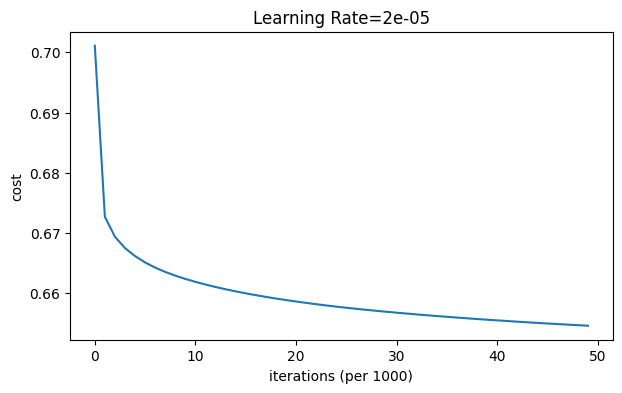

Accuracy: 0.6533333333333333


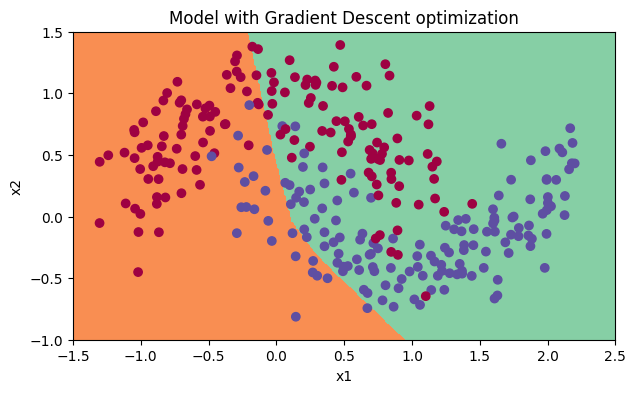

In [46]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Notice that if you set the decay to occur at every iteration, the learning rate goes to zero too quickly - even if you start with a higher learning rate. 
<table> 
    <tr>
        <td>
        <b>Epoch Number</b>
        </td>
        <td>
        <b>Learning Rate</b>
        </td>
        <td>
        <b>Cost</b>
        </td>
    </tr>
    <tr>
        <td>
        0
        </td>
        <td>
        0.100000
        </td>
        <td>
        0.701091
        </td>
    </tr>
    <tr>
        <td>
        1000
        </td>
        <td>
        0.000100
        </td>
        <td>
        0.661884
        </td>
    </tr>
    <tr>
        <td>
        2000
        </td>
        <td>
        0.000050
        </td>
        <td>
        0.658620
        </td>
    </tr>
    <tr>
        <td>
        3000
        </td>
        <td>
        0.000033
        </td>
        <td>
        0.656765
        </td>
    </tr>
    <tr>
        <td>
        4000
        </td>
        <td>
        0.000025
        </td>
        <td>
        0.655486
        </td>
    </tr>
    <tr>
        <td>
        5000
        </td>
        <td>
        0.000020
        </td>
        <td>
        0.654514
        </td>
    </tr>
</table> 

When you're training for a few epoch this doesn't cause a lot of troubles, but when the number of epochs is large the optimization algorithm will stop updating. One common fix to this issue is to decay the learning rate every few steps. This is called fixed interval scheduling.

<a name='7-2'></a> 
### 7.2 - Fixed Interval Scheduling

You can help prevent the learning rate speeding to zero too quickly by scheduling the exponential learning rate decay at a fixed time interval, for example 1000. You can either number the intervals, or divide the epoch by the time interval, which is the size of window with the constant learning rate. 

<img src="images/lr.png" style="width:400px;height:250px;">

<a name='ex-8'></a> 
### Exercise 8 - schedule_lr_decay

Calculate the new learning rate using exponential weight decay with fixed interval scheduling.

**Instructions**: Implement the learning rate scheduling such that it only changes when the epochNum is a multiple of the timeInterval.

**Note:** The fraction in the denominator uses the floor operation. 

$$\alpha = \frac{1}{1 + decayRate \times \lfloor\frac{epochNum}{timeInterval}\rfloor} \alpha_{0}$$

**Hint:** [numpy.floor](https://numpy.org/doc/stable/reference/generated/numpy.floor.html)

In [47]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    learning_rate = 1 / (1 + decay_rate * np.floor(epoch_num / time_interval)) * learning_rate0

    return learning_rate

In [48]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)

epoch_num_1 = 10
epoch_num_2 = 100
decay_rate = 0.3
time_interval = 100
learning_rate_1 = schedule_lr_decay(learning_rate, epoch_num_1, decay_rate, time_interval)
learning_rate_2 = schedule_lr_decay(learning_rate, epoch_num_2, decay_rate, time_interval)
print("Updated learning rate after {} epochs: ".format(epoch_num_1), learning_rate_1)
print("Updated learning rate after {} epochs: ".format(epoch_num_2), learning_rate_2)

schedule_lr_decay_test(schedule_lr_decay)

Original learning rate:  0.5
Updated learning rate after 10 epochs:  0.5
Updated learning rate after 100 epochs:  0.3846153846153846
All tests passed


<a name='7-3'></a> 
### 7.3 - Using Learning Rate Decay for each Optimization Method

Below, you'll use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.) 

<a name='7-3-1'></a> 
#### 7.3.1 - Gradient Descent with Learning Rate Decay

Run the following code to see how the model does gradient descent and weight decay.

Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.127161
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.120304
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.117033
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.117512
learning rate after epoch 4000: 0.020000


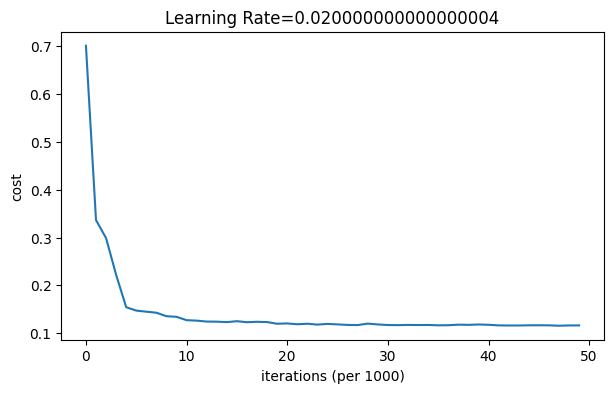

Accuracy: 0.9433333333333334


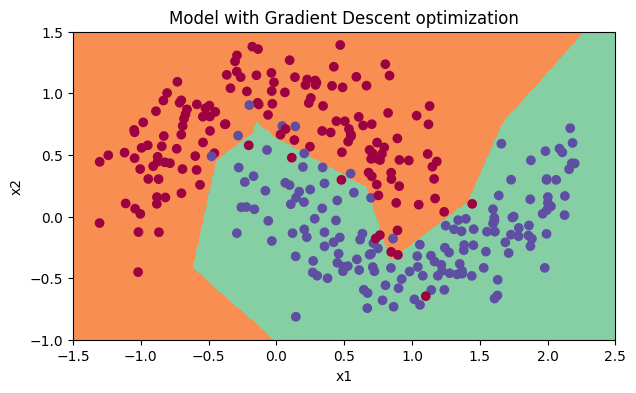

In [49]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<a name='7-3-2'></a> 
#### 7.3.2 - Gradient Descent with Momentum and Learning Rate Decay

Run the following code to see how the model does gradient descent with momentum and weight decay.

In [50]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent with momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

TypeError: initialize_velocity() takes 1 positional argument but 2 were given